# Predicting cause of death from PHMRC VA text narratives using classic NLP methods. 
## Naive Bayes, SVM, K Nearest Neighbor
References: <br>
zhou 2023 circumstances preceding female firearm suicide https://mental.jmir.org/2023/1/e49359/ <br>
https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34 <br>
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [1]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow as tf
import imblearn
import statsmodels.api as sm
import seaborn as sns
import json
from tqdm.auto import tqdm
from transformers import BertTokenizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")

2024-03-27 10:52:40.192100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data

In [2]:
df = pd.read_csv('../../data/phmrc/phmrc_adult_tokenized.csv')

## Train test split

In [3]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['tags'], df['gs_cod'],test_size=0.3)

In [4]:
Train_Y_list = list(Train_Y)
Test_Y_list = list(Test_Y)

## Create embeddings from labeled data

In [5]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['tags'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [6]:
# Create a dictionary where embeddings are keys and strings are values
Train_Y_mapping = {int(embedding): string for string, embedding in zip(Train_Y_list, Train_Y)}
Test_Y_mapping = {int(embedding): string for string, embedding in zip(Test_Y_list, Test_Y)}

In [7]:
# Save the dictionary to a JSON file
with open('cod_embeddings.json', 'w') as file:
    json.dump(Train_Y_mapping, file)

## Naive Bayes Classifier

In [8]:
# fit the training dataset on the NB classifier
NB = naive_bayes.MultinomialNB()
NB.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = NB.predict(Test_X_Tfidf)

# Use accuracy_score and f1_score functions to get the accuracy
NB_accuracy = accuracy_score(predictions_NB, Test_Y)
NB_weighted_f1 = f1_score(predictions_NB, Test_Y, average='weighted')
print("Naive Bayes Accuracy Score -> ", NB_accuracy)
print("Naive Bayes Weighted F1 Score -> ", NB_weighted_f1)

Naive Bayes Accuracy Score ->  0.6155741744701824
Naive Bayes Weighted F1 Score ->  0.7330756466378946


## SVM Classifier

In [9]:
# fit the training dataset on the SVM classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score and f1_score functions to get the accuracy
SVM_accuracy = accuracy_score(predictions_SVM, Test_Y)
SVM_weighted_f1 = f1_score(predictions_SVM, Test_Y, average='weighted')
print("Naive Bayes Accuracy Score -> ", SVM_accuracy)
print("Naive Bayes Weighted F1 Score -> ", SVM_weighted_f1)

Naive Bayes Accuracy Score ->  0.6949236076885165
Naive Bayes Weighted F1 Score ->  0.7562057465163148


## K Nearest Neighbors Classifier

In [43]:
# k=8 with cosine distance
KNN = KNeighborsClassifier(n_neighbors=9, weights='distance', metric='cosine')
KNN.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_KNN = KNN.predict(Test_X_Tfidf)

# Use accuracy_score and f1_score functions to get the accuracy
KNN_accuracy = accuracy_score(predictions_KNN, Test_Y)
KNN_weighted_f1 = f1_score(predictions_KNN, Test_Y, average='weighted')
print("Naive Bayes Accuracy Score -> ", KNN_accuracy)
print("Naive Bayes Weighted F1 Score -> ", KNN_weighted_f1)

Naive Bayes Accuracy Score ->  0.6525381961557417
Naive Bayes Weighted F1 Score ->  0.6944519387591063


## Results

In [11]:
accuracy_scores = {'NB': NB_accuracy, 'KNN': KNN_accuracy, 'SVM': SVM_accuracy}
weighted_f1_scores = {'NB': NB_weighted_f1, 'KNN': KNN_weighted_f1, 'SVM': SVM_weighted_f1}

## Plot Differences

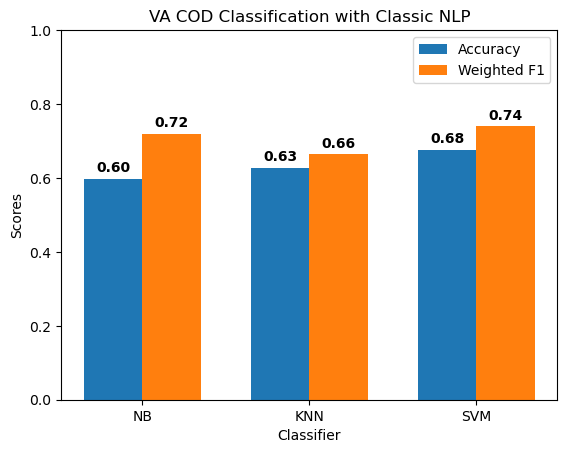

In [12]:
# Example scores (replace these with your actual scores)
models = ['NB', 'KNN', 'SVM']
accuracy_scores = {'NB': NB_accuracy, 'KNN': KNN_accuracy, 'SVM': SVM_accuracy}
weighted_f1_scores = {'NB': NB_weighted_f1, 'KNN': KNN_weighted_f1, 'SVM': SVM_weighted_f1}

# Plotting
bar_width = 0.35
index = np.arange(len(models))

fig, ax = plt.subplots()

bar1 = ax.bar(index, list(accuracy_scores.values()), bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, list(weighted_f1_scores.values()), bar_width, label='Weighted F1')

ax.set_xlabel('Classifier')
ax.set_ylabel('Scores')
ax.set_title('VA COD Classification with Classic NLP')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
# Setting y-axis limits
ax.set_ylim(0, 1.0)
ax.legend()

# Adding labels on top of the bars
for i, v in enumerate(list(accuracy_scores.values())):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

for i, v in enumerate(list(weighted_f1_scores.values())):
    ax.text(i + bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [13]:
# Convert list of embeddings to list of strings using the dictionary
predictions_NB_text = [Train_Y_mapping[embedding] for embedding in predictions_NB]
predictions_SVM_text = [Train_Y_mapping[embedding] for embedding in predictions_SVM]
predictions_KNN_text = [Train_Y_mapping[embedding] for embedding in predictions_KNN]

In [14]:
# go back the other way. list of strings to list of embeddings
temp = list(map(lambda x: next(key for key, value in Train_Y_mapping.items() if value == x), predictions_NB_text))

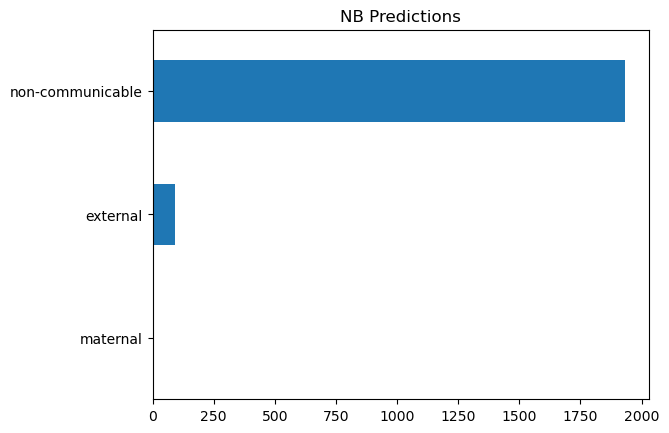

In [15]:
pd.Series(predictions_NB_text).value_counts().plot.barh(title='NB Predictions').invert_yaxis()

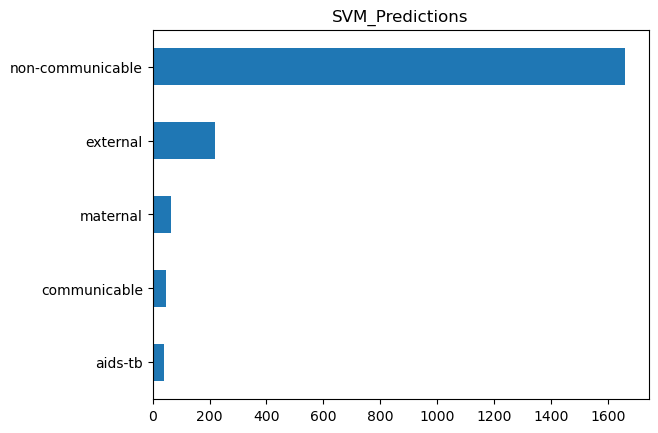

In [16]:
pd.Series(predictions_SVM_text).value_counts().plot.barh(title='SVM_Predictions').invert_yaxis()

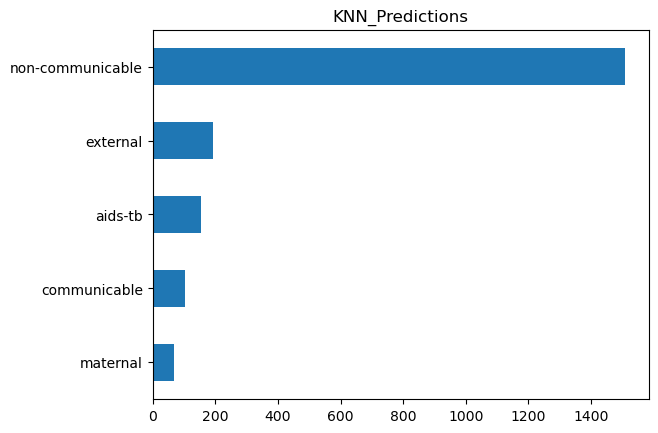

In [17]:
pd.Series(predictions_KNN_text).value_counts().plot.barh(title='KNN_Predictions').invert_yaxis()

##  Plot Total predictions, FP and FN for each class by model

In [18]:
def plot_confusion_bar(true_labels, predicted_labels, classes, color_mapping):
    """
    Create a horizontal bar plot to visualize the counts of total predictions, false positives, and false negatives for each class.

    Parameters:
    - true_labels (list): List of true class labels.
    - predicted_labels (list): List of predicted class labels.
    - classes (list): List of unique class labels.
    - color_mapping (dict): Dictionary mapping unique values to colors.

    Returns:
    None (displays the plot).

    Example:
    >>> true_labels = [1, 0, 1, 1, 0, 0, 1, 0, 1]
    >>> predicted_labels = [1, 0, 1, 0, 1, 0, 1, 1, 0]
    >>> classes = ['non-communicable', 'communicable', 'external', 'maternal', 'aids-tb']
    >>> colors = sns.color_palette("Set2", n_colors=len(df['gs_cod'].unique()))
    >>> unique_cod = df['gs_cod'].unique()
    >>> color_mapping = {value: colors[i] for i, value in enumerate(unique_cod)}
    >>> plot_confusion_bar(true_labels, predicted_labels, classes, color_mapping)
    """
    
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

    # Calculate counts of false positives and false negatives
    fp_counts = np.sum(cm, axis=0)
    fn_counts = np.sum(cm, axis=1) - np.diag(cm)

    # Get the total count of predictions for each class
    total_counts = np.sum(cm, axis=1)

    # Sort classes based on total predictions in descending order
    sorted_indices = np.argsort(total_counts)[::-1]
    sorted_classes = [classes[i] for i in sorted_indices]

    # Create a horizontal bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.25
    indices = np.arange(len(sorted_classes))

    # Plot total predictions as "Predictions"
    total_colors = [color_mapping[cls] for cls in sorted_classes]
    ax.barh(indices, [total_counts[classes.index(cls)] for cls in sorted_classes], color=total_colors, label='Predictions', height=bar_width)

#     # Plot false positives
#     ax.barh(indices + bar_width, [fp_counts[classes.index(cls)] for cls in sorted_classes], 
#             color=sns.light_palette("grey")[2], label='False Positives', height=bar_width)

#     # Plot false negatives
#     ax.barh(indices + 2 * bar_width, [fn_counts[classes.index(cls)] for cls in sorted_classes], 
#             color=sns.light_palette("grey")[4], label='False Negatives', height=bar_width)

    # Set labels, title, and legend
    ax.set(yticks=indices + bar_width, yticklabels=sorted_classes, ylim=[-bar_width, len(sorted_classes) + 3 * bar_width - 1])
    
    # Move the legend to the lower right
    ax.legend(loc='lower right')

    ax.invert_yaxis()  # Invert the y-axis

    plt.xlabel('Count')
    plt.title('Predicted COD with False Positives and Negatives')
    plt.show()

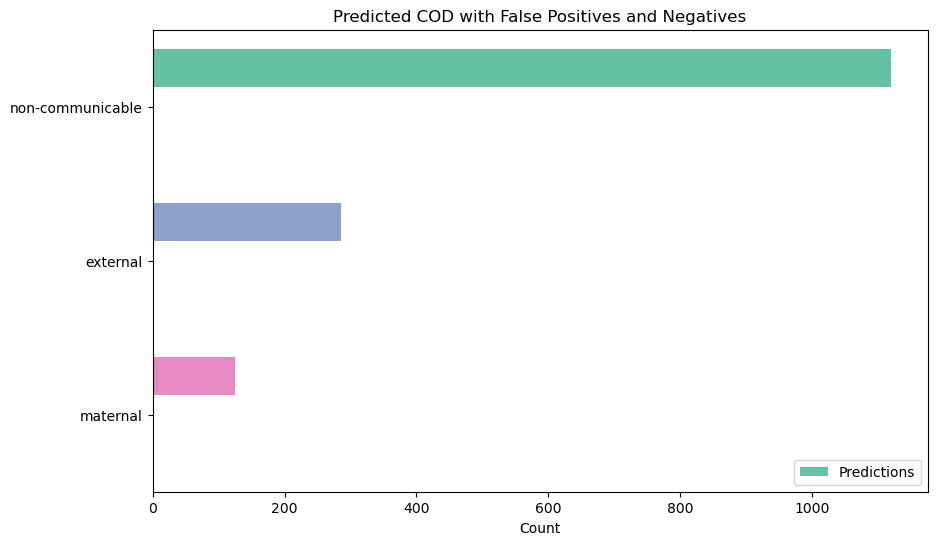

In [19]:
# define labels for comparison
true_labels = [Train_Y_mapping[embedding] for embedding in Test_Y]
predicted_labels = predictions_NB_text
classes = list(pd.Series(predictions_NB_text).unique())

# Create a mapping between unique values in 'gs_cod' and colors
colors = sns.color_palette("Set2", n_colors=len(df['gs_cod'].unique()))
unique_cod = df['gs_cod'].unique()
color_mapping = {value: colors[i] for i, value in enumerate(unique_cod)}

plot_confusion_bar(true_labels, predicted_labels, classes, color_mapping)

## Loop through models and plot on 1x3 grid

non-communicable    1508
external             194
aids-tb              154
communicable         105
maternal              68
Name: count, dtype: int64


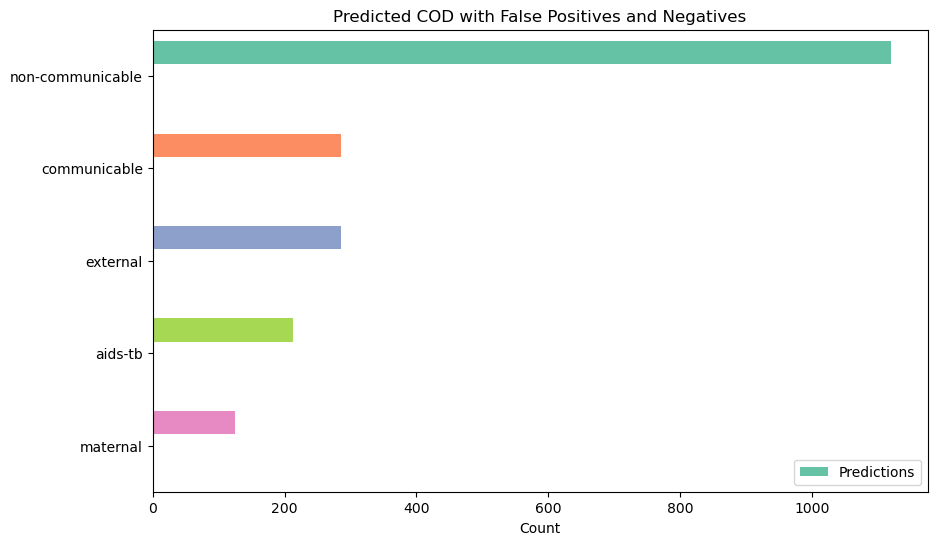

non-communicable    1932
external              92
maternal               5
Name: count, dtype: int64


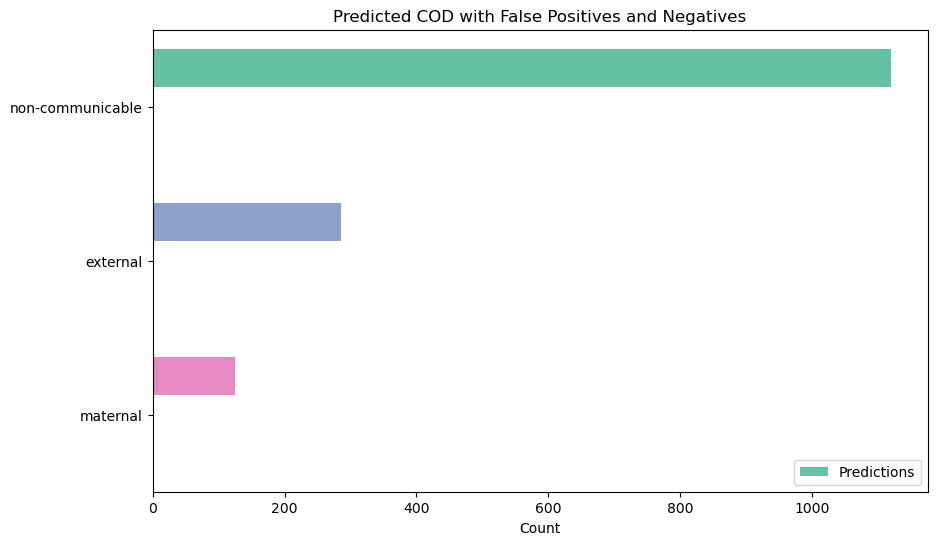

non-communicable    1660
external             218
maternal              63
communicable          48
aids-tb               40
Name: count, dtype: int64


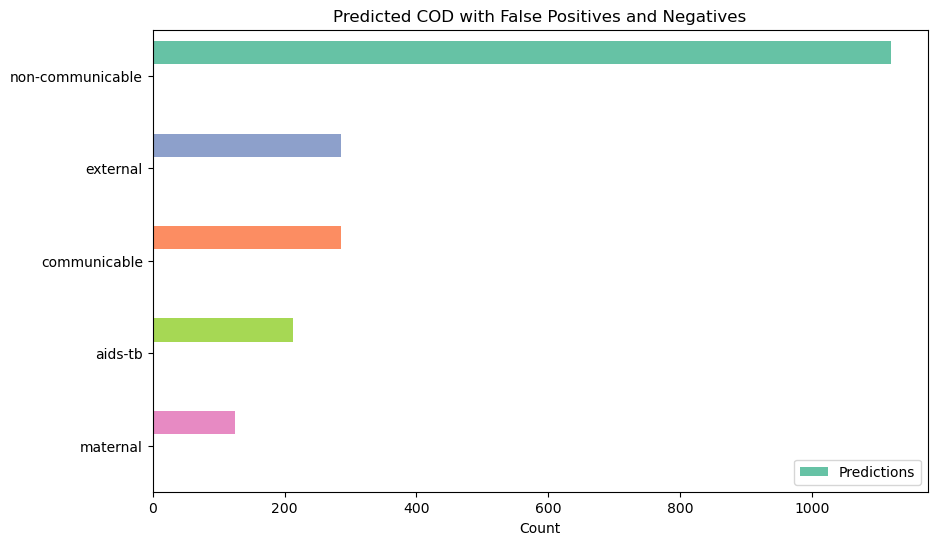

In [20]:
# create list of predictions lists
predictions_all = [predictions_KNN_text, predictions_NB_text, predictions_SVM_text]

for i, prediction in enumerate(predictions_all):
    # define labels for comparison
    true_labels = [Train_Y_mapping[embedding] for embedding in Test_Y]
    predicted_labels = prediction
    classes = list(pd.Series(prediction).unique())
    
    print(pd.Series(predicted_labels).value_counts())

    # Create a mapping between unique values in 'gs_cod' and colors
    colors = sns.color_palette("Set2", n_colors=len(df['gs_cod'].unique()))
    unique_cod = df['gs_cod'].unique()
    color_mapping = {value: colors[i] for i, value in enumerate(unique_cod)}

    plot_confusion_bar(true_labels, predicted_labels, classes, color_mapping)

## Using covariates to predict on Y_nlp. 
### A. 6 baseline betas - for each site, regress true Y on X.
### B. 6 transportability betas.
### C. 6 ppi++ corrected betas. 

## Saving data for Trinity

In [21]:
# df.loc[Test_X.index][['age_yr']].to_csv('baseline_covariates.csv')

In [22]:
# predictions_df = pd.DataFrame({'Test_Y': Test_Y, 
#                                'predictions_NB': predictions_NB,
#                                'predictions_SVM': predictions_SVM, 
#                                'predictions_KNN': predictions_KNN})
# predictions_df.to_csv('baseline_predictions.csv', index=False)

## Load data as Trinity

In [23]:
# # covariates with just age
# Test_X_covariates = pd.read_csv('covariates.csv')
# Test_X_covariates = Test_X_covariates['age_yr']

# # # covariates with age and education
# Test_X_covariates = pd.read_csv('covariates.csv')

# # predictions from 3 NLP classifiers plus the true labels (Test_Y)
# predictions_df = pd.read_csv('predictions.csv')

# Test_Y = predictions_df['Test_Y']
# predictions_NB = predictions_df['predictions_NB']
# predictions_SVM = predictions_df['predictions_SVM']
# predictions_KNN = predictions_df['predictions_KNN']

## sklearn for Multinomial Logistic Regression 

In [24]:
# # using sklearn for the multinomial logistic regression
# model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# NB_baseline = model.fit(np.array(list(Test_X_covariates)).reshape(-1,1), predictions_NB)
# SVM_baseline = model.fit(np.array(list(Test_X_covariates)).reshape(-1,1), predictions_SVM)
# KNN_baseline = model.fit(np.array(list(Test_X_covariates)).reshape(-1,1), predictions_KNN)

## statsmodels.api for the multinomial linear regression


In [25]:
# # Add a constant term to the features for the intercept
# Test_X_covariates_constant = sm.add_constant(np.array(Test_X_covariates).reshape(-1,1))

# # Fit the multinomial logistic regression models using Statsmodels
# NB_baseline = sm.MNLogit(predictions_NB, Test_X_covariates_constant, check_rank=True).fit(method='bfgs')
# SVM_baseline = sm.MNLogit(predictions_SVM, Test_X_covariates_constant, check_rank=True).fit(method='bfgs')
# KNN_baseline = sm.MNLogit(predictions_KNN, Test_X_covariates_constant, check_rank=True).fit(method='bfgs')

## Ground Truth Parameter Estimates - For each site, regress Gold Label Y on X

In [26]:
regions = df['site'].unique()

In [27]:
# write function to loop through sites and perform sm.MNLogit prediction of True Y on X, and return df of 

def mnlogit(df, site):
    '''
    takes in dataframe and site name as a string
    runs sm.MNlogit on Y and X 
    returns parameter point estimates and standard errors as a df 
    '''
    # Get Y and X for regressing
    df_site = df[df['site']==site]
    Y_text = df_site['gs_cod']
    # get integer embedding from text using mapping dict
    df_site['gs_cod_embed'] = list(map(lambda x: next(key for key, value in Train_Y_mapping.items() if value == x), Y_text))
    df_site.sort_values(by='gs_cod_embed', ascending=True)['gs_cod_embed']
    Y = df_site['gs_cod_embed']
    X = df_site['age_yr']

    # Reorder the unique values so that 0 becomes the reference category
    df_site['gs_cod_embed'] = pd.Categorical(df_site['gs_cod_embed'], categories=[0,1,2,3,4], ordered=True)

    print(site)
    print(df_site.shape)
    
    # Create design matrices
    X = df_site['age_yr']
    X = sm.add_constant(X)
    y = pd.get_dummies(df_site['gs_cod_embed'])

    # Fit the multinomial logistic regression model
    model = sm.MNLogit(y, X)
    result = model.fit()

    # output table just to verify the levels are correct
    print(result.summary())

    # Extract labels, parameter estimates and standard errors
    class_labels = result.model.endog_names
    age_yr_params = result.params.loc['age_yr']
    age_yr_std_errors = result.bse.loc['age_yr']

    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Class': [1,2,3,4], # HARD CODED -> IDK HOW TO GET THIS OUTPUT FROM result
        'Parameter Estimate': age_yr_params,
        'Standard Error': age_yr_std_errors
    })
    
    return results_df

In [28]:
# Loop through the list of sites and output results to csv
sites = df['site'].unique()

for site in sites:

    # Create a DataFrame for the results
    results_df = mnlogit(df, site)

    # Save results to a CSV file
    results_df.to_csv(f'ground_truth_{site}.csv', index=False)

mexico
(1306, 13)
Optimization terminated successfully.
         Current function value: 0.930912
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1306
Model:                        MNLogit   Df Residuals:                     1298
Method:                           MLE   Df Model:                            4
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                 0.08812
Time:                        10:11:26   Log-Likelihood:                -1215.8
converged:                       True   LL-Null:                       -1333.3
Covariance Type:            nonrobust   LLR p-value:                 1.119e-49
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0209      0.396     -7.628      0.000      -3.797      -2.245
age_yr     

                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  260
Model:                        MNLogit   Df Residuals:                      252
Method:                           MLE   Df Model:                            4
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                 0.06082
Time:                        10:11:26   Log-Likelihood:                -349.57
converged:                       True   LL-Null:                       -372.21
Covariance Type:            nonrobust   LLR p-value:                 3.490e-09
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4187      1.236      2.766      0.006       0.996       5.841
age_yr        -0.0230      0.021     -1.086      0.278      -0.065       0.019
----------------------------------------------------